In [3]:
import tensorflow as tf
import numpy as np
import cv2
import zipfile
import os
from sklearn.model_selection import train_test_split
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [2]:
# Path ke file ZIP dan direktori tujuan
zip_path = 'C:/Image1.zip'
Dataset = './Dataset'

# Jika direktori dataset sudah ada, hapus dan buat ulang
if os.path.exists(Dataset):
    shutil.rmtree(Dataset)  # Hapus direktori lama
os.makedirs(Dataset, exist_ok=True)  # Buat ulang direktori

# Ekstrak data dari file ZIP
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(Dataset)


In [5]:
classes = [
    'Acne',
    'Actinic Cheilitis',
    'Actinic Keratosis',
    'Basall Cell Carcinoma',
    'Bullous Disease',
    'Cacar Air',
    'Eczema',
    'Infeksi Jamur',
    'Kutil',
    'Skin Cancer',
    'Urticaria Hives',
]

In [4]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Direktori asli dataset
dataset_dir = 'Dataset'   # Path dari variabel sebelumnya

# Direktori untuk train dan test
TRAIN_DIR = './Dataset/train'
TEST_DIR = './Dataset/test'

# Daftar kelas atau label dalam dataset
classes = os.listdir(dataset_dir)  # Ini akan mengambil nama folder dalam dataset_dir sebagai label

# Hapus dan buat ulang direktori train dan test jika sudah ada
if os.path.exists(TRAIN_DIR):
    shutil.rmtree(TRAIN_DIR)
if os.path.exists(TEST_DIR):
    shutil.rmtree(TEST_DIR)

os.makedirs(TRAIN_DIR, exist_ok=True)
os.makedirs(TEST_DIR, exist_ok=True)

# Bagi dataset menjadi train dan test
for label in classes:
    label_dir = os.path.join(dataset_dir, label)
    if os.path.exists(label_dir):
        files = os.listdir(label_dir)
        train_files, test_files = train_test_split(
            files, test_size=0.1, random_state=42
        )

        # Buat subdirektori untuk train dan test per label
        os.makedirs(os.path.join(TRAIN_DIR, label), exist_ok=True)
        os.makedirs(os.path.join(TEST_DIR, label), exist_ok=True)

        # Salin file ke direktori train
        for file in train_files:
            src = os.path.join(label_dir, file)
            dst = os.path.join(TRAIN_DIR, label, file)
            shutil.copy(src, dst)

        # Salin file ke direktori test
        for file in test_files:
            src = os.path.join(label_dir, file)
            dst = os.path.join(TEST_DIR, label, file)
            shutil.copy(src, dst)

print("Dataset berhasil dibagi menjadi train dan test.")


Dataset berhasil dibagi menjadi train dan test.


In [5]:
import pandas as pd
TRAIN_DIR = './Dataset/train'
TEST_DIR = './Dataset/test'

# Membuat daftar jumlah data untuk setiap label
data_summary = []

for disease in classes:
    train_path = os.path.join(TRAIN_DIR, disease)
    test_path = os.path.join(TEST_DIR, disease)

    train_count = len(os.listdir(train_path)) if os.path.exists(train_path) else 0
    test_count = len(os.listdir(test_path)) if os.path.exists(test_path) else 0

    data_summary.append({'Disease': disease, 'Train': train_count, 'Test': test_count})

# Membuat tabel menggunakan pandas
df_summary = pd.DataFrame(data_summary)

# Menampilkan tabel
print(df_summary)



                  Disease  Train  Test
0                    Acne    123    14
1       Actinic Cheilitis     49     6
2       Actinic Keratosis     90    10
3   Basall Cell Carcinoma    161    18
4         Bullous Disease     19     3
5               Cacar Air     35     4
6                  Eczema     29     4
7           Infeksi jamur     31     4
8                   Kutil     48     6
9             Skin Cancer     37     5
10        Urticaria Hives     22     3


In [6]:
def blur_watermark(image_path, output_path):
    """
    Memburamkan area watermark secara otomatis dengan lebar 2/4 bagian
    dan tinggi 1/5 bagian di tengah gambar.
    """
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"File {image_path} tidak dapat dimuat.")

    h, w, _ = image.shape

    # Tentukan area blur
    center_y, center_x = h // 2, w // 2
    box_h = h // 5  # Tinggi blur 1/5 bagian
    box_w = w // 2  # Lebar blur 2/4 bagian (setengah lebar gambar)
    y_min = max(center_y - box_h // 2, 0)
    y_max = min(center_y + box_h // 2, h)
    x_min = max(center_x - box_w // 2, 0)
    x_max = min(center_x + box_w // 2, w)

    # Blur area di tengah
    watermark_region = image[y_min:y_max, x_min:x_max]
    blurred_region = cv2.GaussianBlur(watermark_region, (21, 21), 0)
    image[y_min:y_max, x_min:x_max] = blurred_region

    cv2.imwrite(output_path, image)

def preprocess_dataset(input_dir, output_dir):
    """
    Memburamkan watermark di dataset. Mendukung folder dengan subfolder kategori.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for class_name in os.listdir(input_dir):
        class_input_dir = os.path.join(input_dir, class_name)
        class_output_dir = os.path.join(output_dir, class_name)

        if not os.path.isdir(class_input_dir):
            print(f"Skipping non-folder: {class_input_dir}")
            continue

        if not os.path.exists(class_output_dir):
            os.makedirs(class_output_dir)

        for image_name in os.listdir(class_input_dir):
            image_path = os.path.join(class_input_dir, image_name)
            output_path = os.path.join(class_output_dir, image_name)

            if not image_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                print(f"Skipping non-image file: {image_path}")
                continue

            try:
                blur_watermark(image_path, output_path)
            except Exception as e:
                print(f"Error processing {image_path}: {e}")

# Hapus hasil sebelumnya
output_dir = './Processed'
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)
    print(f"Folder {output_dir} berhasil dihapus.")

# Proses ulang dataset
preprocess_dataset('./Dataset/train', './Processed/train')
preprocess_dataset('./Dataset/test', './Processed/test')

print("Proses blur selesai.")

Folder ./Processed berhasil dihapus.
Proses blur selesai.


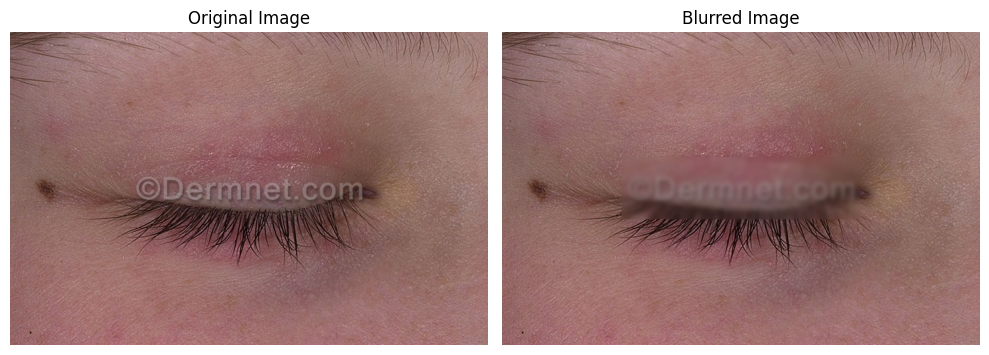

In [8]:
import matplotlib.pyplot as plt

def show_blurred_image(original_path, blurred_path):
    """
    Menampilkan gambar asli dan hasil blur secara berdampingan.
    """
    # Muat gambar asli dan hasil blur
    original_image = cv2.imread(original_path)
    blurred_image = cv2.imread(blurred_path)
    
    if original_image is None or blurred_image is None:
        raise ValueError("Salah satu gambar tidak dapat dimuat.")
    
    # Konversi warna dari BGR ke RGB untuk ditampilkan di matplotlib
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    blurred_image = cv2.cvtColor(blurred_image, cv2.COLOR_BGR2RGB)
    
    # Plot gambar
    plt.figure(figsize=(10, 5))
    
    # Gambar asli
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis("off")
    
    # Gambar yang diburamkan
    plt.subplot(1, 2, 2)
    plt.imshow(blurred_image)
    plt.title("Blurred Image")
    plt.axis("off")
    
    plt.tight_layout()
    plt.show()

# Contoh penggunaan
original_image_path = './Dataset/train/Acne/07PerioralDermEye.jpg'  
blurred_image_path = './Processed/train/Acne/07PerioralDermEye.jpg'  

show_blurred_image(original_image_path, blurred_image_path)


In [9]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

TRAIN_DIR = './Processed/train'
TEST_DIR = './Processed/test'
#TRAIN_DIR = './Dataset/train'
#TEST_DIR = './Dataset/test'
def balance_data(dataset_dir, target_count=450):
    """
    Menyeimbangkan jumlah data dalam setiap kelas menggunakan augmentasi gambar,
    dengan augmentasi dilakukan untuk semua gambar di folder secara merata.
    """
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2, 
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    # Daftar semua kelas
    classes = os.listdir(dataset_dir)
    
    for cls in classes:
        class_dir = os.path.join(dataset_dir, cls)
        images = os.listdir(class_dir)
        
        # Hitung jumlah gambar yang perlu dibuat
        if len(images) < target_count:
            images_to_generate = target_count - len(images)
            print(f"Augmentasi {images_to_generate} gambar untuk kelas: {cls}")
            
            # Hitung augmentasi per gambar
            augment_per_image = images_to_generate // len(images)
            remainder = images_to_generate % len(images)  # Jika tidak habis dibagi
            
            generated_count = 0
            
            # Augmentasi setiap gambar
            for idx, image_file in enumerate(images):
                img_path = os.path.join(class_dir, image_file)
                img = load_img(img_path)  # Corrected: load_img from tensorflow.keras.preprocessing.image
                img_array = img_to_array(img)  # Corrected: img_to_array from tensorflow.keras.preprocessing.image
                img_array = np.expand_dims(img_array, axis=0)
                
                # Hitung jumlah augmentasi untuk gambar ini
                num_augment = augment_per_image + (1 if idx < remainder else 0)  # Tambahkan sisa augmentasi
                
                # Augmentasi gambar
                for batch in datagen.flow(
                    img_array, 
                    batch_size=1,   
                    save_to_dir=class_dir, 
                    save_prefix='aug', 
                    save_format='jpeg'
                ):
                    generated_count += 1
                    if generated_count >= images_to_generate:
                        break  # Hentikan jika jumlah target tercapai
                    if num_augment <= 0:
                        break
                    num_augment -= 1

# Seimbangkan data pelatihan
balance_data(TRAIN_DIR)


Augmentasi 327 gambar untuk kelas: Acne
Augmentasi 401 gambar untuk kelas: Actinic Cheilitis
Augmentasi 360 gambar untuk kelas: Actinic Keratosis
Augmentasi 289 gambar untuk kelas: Basall Cell Carcinoma
Augmentasi 431 gambar untuk kelas: Bullous Disease
Augmentasi 415 gambar untuk kelas: Cacar Air
Augmentasi 421 gambar untuk kelas: Eczema
Augmentasi 419 gambar untuk kelas: Infeksi jamur
Augmentasi 402 gambar untuk kelas: Kutil
Augmentasi 413 gambar untuk kelas: Skin Cancer
Augmentasi 428 gambar untuk kelas: Urticaria Hives


In [10]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

TRAIN_DIR = './Processed/train'
TEST_DIR = './Processed/test'
#TRAIN_DIR = './Dataset/train'
#TEST_DIR = './Dataset/test'
def balance_data(dataset_dir, target_count=100):
    """
    Menyeimbangkan jumlah data dalam setiap kelas menggunakan augmentasi gambar,
    dengan augmentasi dilakukan untuk semua gambar di folder secara merata.
    """
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2, 
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    # Daftar semua kelas
    classes = os.listdir(dataset_dir)
    
    for cls in classes:
        class_dir = os.path.join(dataset_dir, cls)
        images = os.listdir(class_dir)
        
        # Hitung jumlah gambar yang perlu dibuat
        if len(images) < target_count:
            images_to_generate = target_count - len(images)
            print(f"Augmentasi {images_to_generate} gambar untuk kelas: {cls}")
            
            # Hitung augmentasi per gambar
            augment_per_image = images_to_generate // len(images)
            remainder = images_to_generate % len(images)  # Jika tidak habis dibagi
            
            generated_count = 0
            
            # Augmentasi setiap gambar
            for idx, image_file in enumerate(images):
                img_path = os.path.join(class_dir, image_file)
                img = load_img(img_path)  # Corrected: load_img from tensorflow.keras.preprocessing.image
                img_array = img_to_array(img)  # Corrected: img_to_array from tensorflow.keras.preprocessing.image
                img_array = np.expand_dims(img_array, axis=0)
                
                # Hitung jumlah augmentasi untuk gambar ini
                num_augment = augment_per_image + (1 if idx < remainder else 0)  # Tambahkan sisa augmentasi
                
                # Augmentasi gambar
                for batch in datagen.flow(
                    img_array, 
                    batch_size=1,   
                    save_to_dir=class_dir, 
                    save_prefix='aug', 
                    save_format='jpeg'
                ):
                    generated_count += 1
                    if generated_count >= images_to_generate:
                        break  # Hentikan jika jumlah target tercapai
                    if num_augment <= 0:
                        break
                    num_augment -= 1

# Seimbangkan data pelatihan
balance_data(TEST_DIR)


Augmentasi 86 gambar untuk kelas: Acne
Augmentasi 94 gambar untuk kelas: Actinic Cheilitis
Augmentasi 90 gambar untuk kelas: Actinic Keratosis
Augmentasi 82 gambar untuk kelas: Basall Cell Carcinoma
Augmentasi 97 gambar untuk kelas: Bullous Disease
Augmentasi 96 gambar untuk kelas: Cacar Air
Augmentasi 96 gambar untuk kelas: Eczema
Augmentasi 96 gambar untuk kelas: Infeksi jamur
Augmentasi 94 gambar untuk kelas: Kutil
Augmentasi 95 gambar untuk kelas: Skin Cancer
Augmentasi 97 gambar untuk kelas: Urticaria Hives


In [13]:
import pandas as pd
TRAIN_DIR = './Processed/train'
TEST_DIR = './Processed/test'

# Membuat daftar jumlah data untuk setiap label
data_summary = []

for disease in classes:
    train_path = os.path.join(TRAIN_DIR, disease)
    test_path = os.path.join(TEST_DIR, disease)

    train_count = len(os.listdir(train_path)) if os.path.exists(train_path) else 0
    test_count = len(os.listdir(test_path)) if os.path.exists(test_path) else 0

    data_summary.append({'Disease': disease, 'Train': train_count, 'Test': test_count})

# Membuat tabel menggunakan pandas
df_summary = pd.DataFrame(data_summary)

# Menampilkan tabel
print(df_summary)



                  Disease  Train  Test
0                    Acne    483   101
1       Actinic Cheilitis    443    99
2       Actinic Keratosis    463   100
3   Basall Cell Carcinoma    510   103
4         Bullous Disease    441    98
5               Cacar Air    444   100
6                  Eczema    441    99
7           Infeksi jamur    442   100
8                   Kutil    443   100
9             Skin Cancer    447    99
10        Urticaria Hives    442    99


In [14]:
import matplotlib.pyplot as plt
import tensorflow as tf
import os

def show_augmented_samples(dataset_dir, class_name, sample_to_display=5):
    """
    Menampilkan gambar hasil augmentasi dari folder tertentu.
    """
    class_dir = os.path.join(dataset_dir, class_name)
    augmented_images = [f for f in os.listdir(class_dir) if f.startswith('aug')]
    
    if not augmented_images:
        print(f"Tidak ada gambar augmentasi ditemukan di kelas: {class_name}")
        return
    
    print(f"Menampilkan {min(sample_to_display, len(augmented_images))} gambar hasil augmentasi untuk kelas: {class_name}")
    for i, image_file in enumerate(augmented_images[:sample_to_display]):
        img_path = os.path.join(class_dir, image_file)
        img = tf.keras.utils.load_img(img_path)
        
        plt.figure()
        plt.imshow(img)
        plt.title(f"Augmented Image {i+1} - Class: {class_name}")
        plt.axis('off')
    plt.show()

Menampilkan 3 gambar hasil augmentasi untuk kelas: Acne


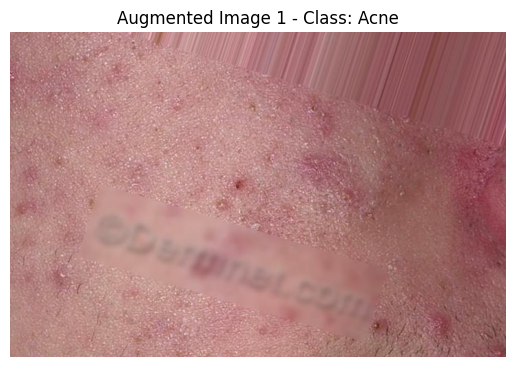

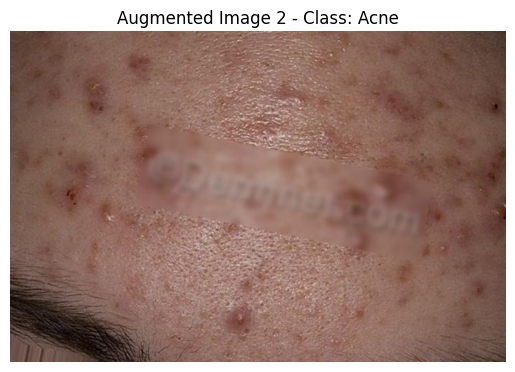

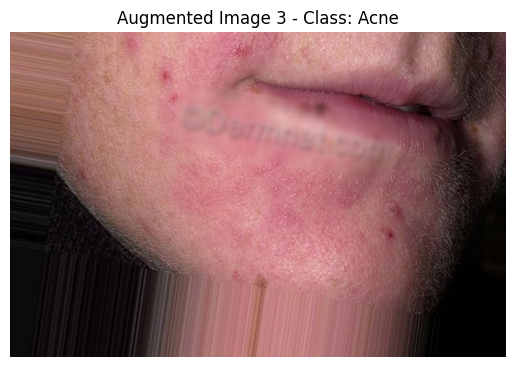

In [15]:
show_augmented_samples(TRAIN_DIR, class_name='Acne', sample_to_display=3)

Menampilkan 3 gambar hasil augmentasi untuk kelas: Kutil


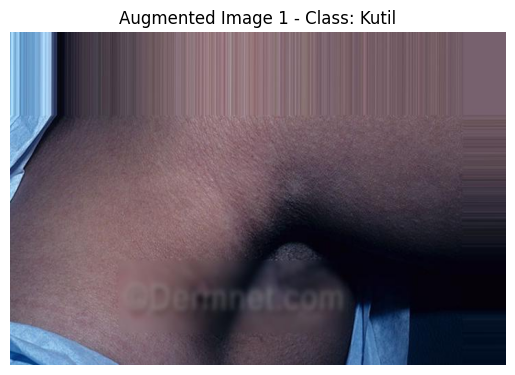

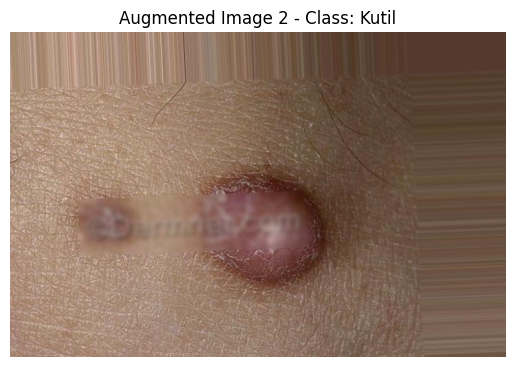

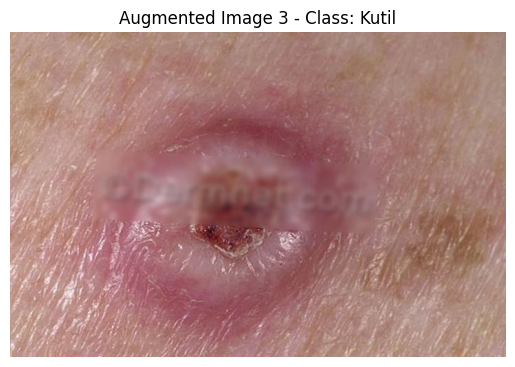

In [16]:
show_augmented_samples(TEST_DIR, class_name='Kutil', sample_to_display=3)

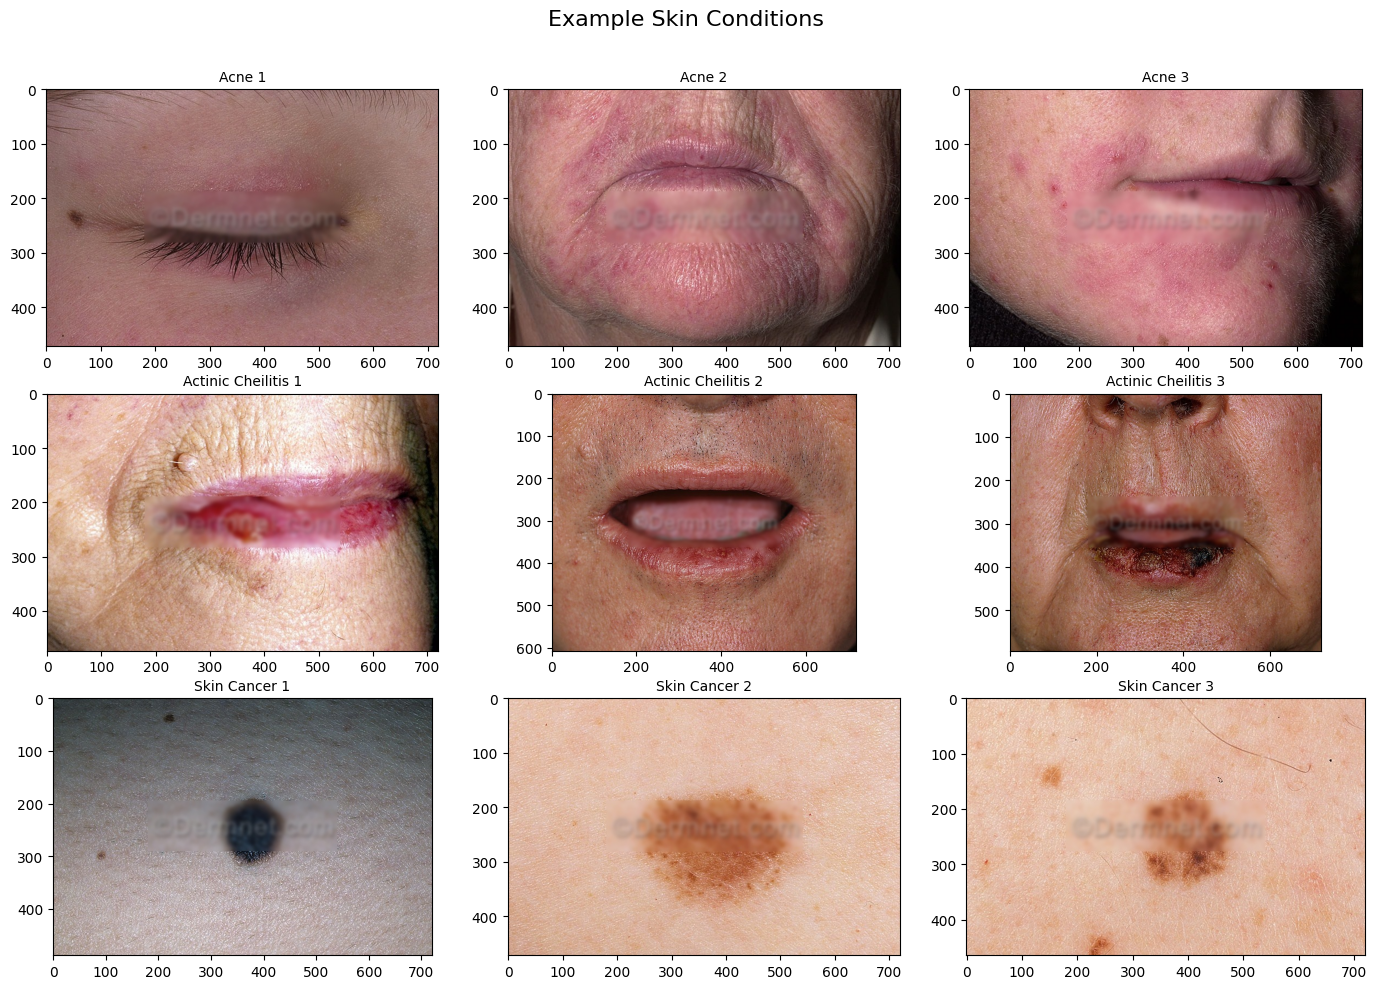

In [17]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf

# Direktori kategori gambar
categories = [
    "./Processed/train/Acne",
    "./Processed/train/Actinic Cheilitis",
    "./Processed/train/Skin Cancer",
]

# Jumlah gambar per kategori yang ditampilkan
num_images_per_category = 3

# Membuat grid plot
fig, axes = plt.subplots(len(categories), num_images_per_category, figsize=(14, 10))
fig.suptitle('Example Skin Conditions', fontsize=16)

# Menampilkan gambar untuk setiap kategori
for row, category in enumerate(categories):
    files = [os.path.join(category, f) for f in os.listdir(category)[:num_images_per_category]]
    for col, img_path in enumerate(files):
        img = tf.keras.utils.load_img(img_path)
        ax = axes[row, col]
        ax.imshow(img)
        ax.set_title(f"{os.path.basename(category)} {col + 1}", fontsize=10)
        ax.axis('on')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Rescaling

# Path direktori data hasil preprocessing
TRAIN_DIR = './Processed/train'
TEST_DIR = './Processed/test'

# Memuat dataset dari direktori
train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=TRAIN_DIR,
    image_size=(180, 180),
    batch_size=64,
    label_mode="int",  # Label sebagai integer
    shuffle=True  # Pastikan data dilatih secara acak
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=TEST_DIR,
    image_size=(180, 180),
    batch_size=64,
    label_mode="int",
    shuffle=False  # Test data tidak perlu diacak
)

# Menstandarisasi dataset (rescale piksel ke [0, 1])
normalization_layer = Rescaling(1.0 / 255)

train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

# Mengoptimalkan pipeline data (prefetching untuk mempercepat training)
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

# Informasi dataset
print(f"Number of training batches: {len(train_dataset)}")
print(f"Number of testing batches: {len(test_dataset)}")


Found 4999 files belonging to 11 classes.
Found 1098 files belonging to 11 classes.
Number of training batches: 79
Number of testing batches: 18


In [19]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_custom_cnn(input_shape, num_classes):
    """Membuat model CNN custom untuk klasifikasi 23 label."""
    model = models.Sequential([
        layers.Input(shape=input_shape),  # Tambahkan Input layer di sini
        
        # Layer convolutional pertama
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        # Layer convolutional kedua
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        # Layer convolutional ketiga
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        # Flatten layer
        layers.Flatten(),
        
        # Fully connected layer
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),  # Mencegah overfitting
        
        # Output layer
        layers.Dense(num_classes, activation='softmax')  # Untuk klasifikasi 23 label
    ])
    
    # Kompilasi model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        #loss='sparse_categorical_crossentropy',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )
    
    return model

# Parameter model
input_shape = (180, 180, 3)  # Gambar 180x180 piksel dengan 3 channel warna
num_classes = 18  # Jumlah label

# Membuat model
model = create_custom_cnn(input_shape, num_classes)

# Menampilkan summary model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 20, 20, 128)      0

In [21]:
class StopAtAccuracy(tf.keras.callbacks.Callback):
    def __init__(self, target_accuracy=0.95):
        super(StopAtAccuracy, self).__init__()
        self.target_accuracy = target_accuracy

    def on_epoch_end(self, epoch, logs=None):
        # Cek akurasi pada training dan validation
        train_acc = logs.get('accuracy')
        val_acc = logs.get('val_accuracy')

        if train_acc and train_acc >= self.target_accuracy:
            print(f"\nAkurasi pelatihan mencapai {train_acc:.2f}. Pelatihan dihentikan.")
            self.model.stop_training = True

        if val_acc and val_acc >= self.target_accuracy:
            print(f"\nAkurasi validasi mencapai {val_acc:.2f}. Pelatihan dihentikan.")
            self.model.stop_training = True
            
# Callback EarlyStopping untuk memantau akurasi validasi
#early_stopping = tf.keras.callbacks.EarlyStopping(
#    monitor='val_accuracy',     # Pantau akurasi validasi
 #   patience=3,                 # Tunggu hingga 3 epoch tanpa peningkatan
  #  restore_best_weights=True,  # Kembalikan bobot terbaik setelah berhenti
   # verbose=1                   # Tampilkan log saat pelatihan dihentikan
#)

# Callback ReduceLROnPlateau untuk menyesuaikan learning rate
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',  # Pantau akurasi validasi
    factor=0.5,              # Kurangi learning rate 50%
#    patience=3,              # Tunggu 3 epoch tanpa peningkatan
    verbose=1,               # Tampilkan informasi perubahan LR
    mode='max'               # Karena kita memaksimalkan akurasi
)

# Melatih model
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=100,  # Jumlah maksimum epoch
    callbacks=[
        StopAtAccuracy(target_accuracy=0.95),  # Callback custom
#        early_stopping,                        # Hentikan jika stagnan
        reduce_lr                              # Sesuaikan learning rate
    ]
)


Epoch 1/100
79/79 [==============================] - 21s 258ms/step - loss: 1.5525 - accuracy: 0.4697 - val_loss: 1.5678 - val_accuracy: 0.4290 - lr: 0.0010
Epoch 2/100
79/79 [==============================] - 18s 234ms/step - loss: 1.2983 - accuracy: 0.5481 - val_loss: 1.3565 - val_accuracy: 0.5209 - lr: 0.0010
Epoch 3/100
79/79 [==============================] - 18s 231ms/step - loss: 1.1807 - accuracy: 0.5887 - val_loss: 1.4894 - val_accuracy: 0.4900 - lr: 0.0010
Epoch 4/100
79/79 [==============================] - 18s 232ms/step - loss: 0.9958 - accuracy: 0.6497 - val_loss: 1.5334 - val_accuracy: 0.5100 - lr: 0.0010
Epoch 5/100
79/79 [==============================] - 18s 232ms/step - loss: 0.9231 - accuracy: 0.6813 - val_loss: 1.5185 - val_accuracy: 0.5182 - lr: 0.0010
Epoch 6/100
79/79 [==============================] - 18s 233ms/step - loss: 0.8093 - accuracy: 0.7293 - val_loss: 1.4794 - val_accuracy: 0.5656 - lr: 0.0010
Epoch 7/100
79/79 [==============================] - 18s 2

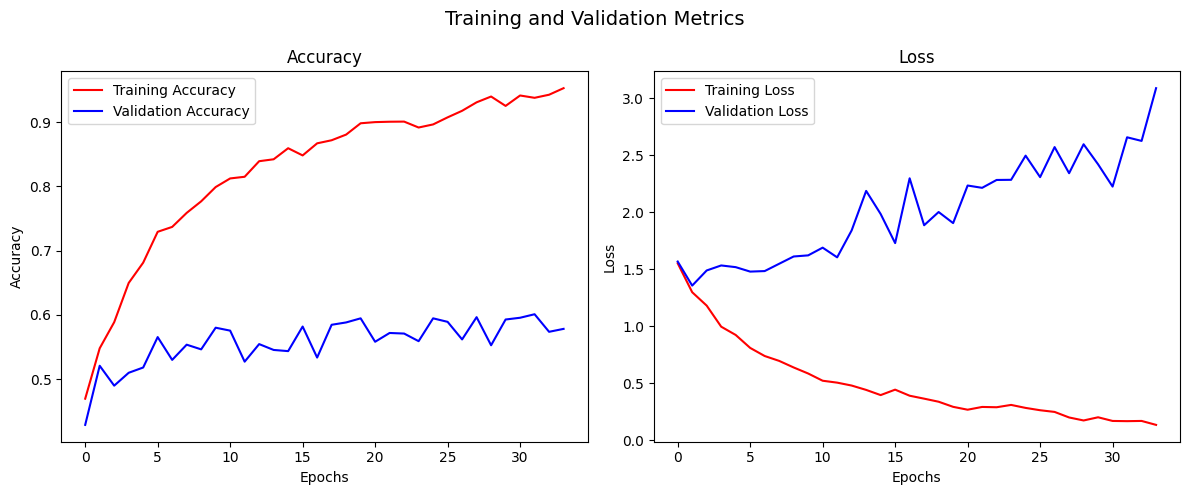

In [22]:
import matplotlib.pyplot as plt  # Pastikan penulisan benar

# Contoh asumsi variabel history (untuk memberikan konteks):
# history = model.fit(...)

# Mendapatkan akurasi dan loss dari pelatihan dan validasi
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Mendapatkan jumlah epoch
epochs = range(len(acc))

# Membuat subplots untuk akurasi dan loss
fig, ax = plt.subplots(1, 2, figsize=(12, 5))  # Lebar disesuaikan untuk visualisasi lebih baik
fig.suptitle('Training and Validation Metrics', fontsize=14)

# Plot akurasi
ax[0].plot(epochs, acc, 'r', label="Training Accuracy")
ax[0].plot(epochs, val_acc, 'b', label="Validation Accuracy")
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

# Plot loss
ax[1].plot(epochs, loss, 'r', label="Training Loss")
ax[1].plot(epochs, val_loss, 'b', label="Validation Loss")
ax[1].set_title('Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()

# Menampilkan plot
plt.tight_layout()
plt.show()


In [35]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
def build_resnet50_model():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(180, 180, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    predictions = Dense(11, activation='softmax')(x)  # Output layer 
    model = Model(inputs=base_model.input, outputs=predictions)
    
    for layer in base_model.layers:
        layer.trainable = False  # Freeze layers

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss=SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])
    return model

# Latih model ResNet50 
resnet50_model = build_resnet50_model()
history_resnet50 = resnet50_model.fit(
    train_dataset,
    epochs=1000,  
    validation_data=test_dataset,  
)

# Menyimpan model terbaik setelah pelatihan
resnet50_model.save("resnet50_best_model.h5")


Epoch 1/1000
79/79 [==============================] - 36s 339ms/step - loss: 2.4225 - accuracy: 0.0948 - val_loss: 2.3933 - val_accuracy: 0.1111
Epoch 2/1000
79/79 [==============================] - 23s 297ms/step - loss: 2.3927 - accuracy: 0.1192 - val_loss: 2.3729 - val_accuracy: 0.1293
Epoch 3/1000
79/79 [==============================] - 24s 298ms/step - loss: 2.3663 - accuracy: 0.1398 - val_loss: 2.3480 - val_accuracy: 0.2049
Epoch 4/1000
79/79 [==============================] - 23s 294ms/step - loss: 2.3411 - accuracy: 0.1544 - val_loss: 2.3230 - val_accuracy: 0.1730
Epoch 5/1000
79/79 [==============================] - 24s 298ms/step - loss: 2.3144 - accuracy: 0.1672 - val_loss: 2.2969 - val_accuracy: 0.1831
Epoch 6/1000
79/79 [==============================] - 23s 294ms/step - loss: 2.2886 - accuracy: 0.1818 - val_loss: 2.2736 - val_accuracy: 0.1976
Epoch 7/1000
79/79 [==============================] - 23s 291ms/step - loss: 2.2680 - accuracy: 0.1890 - val_loss: 2.2507 - val_ac

KeyboardInterrupt: 

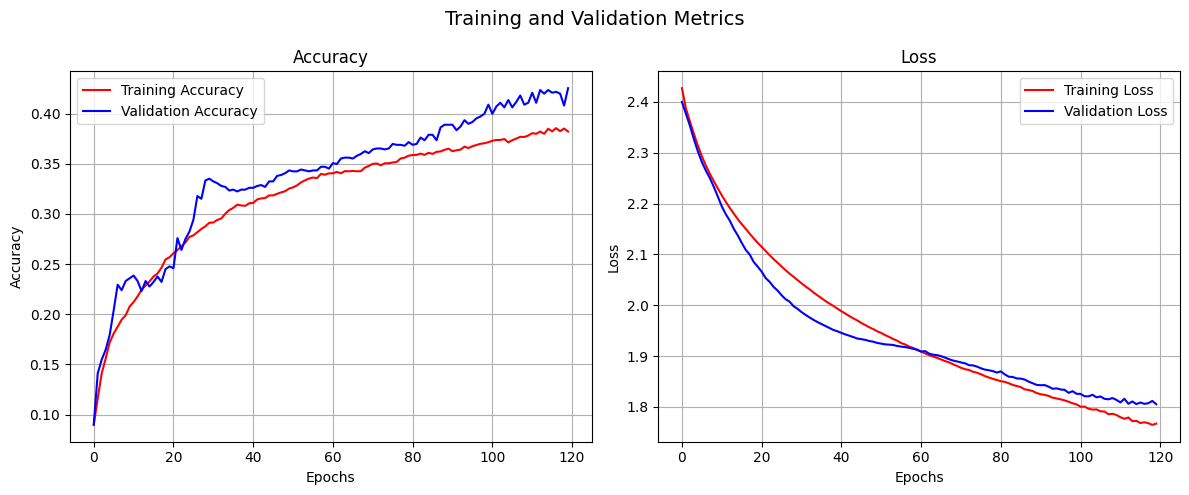

In [15]:
import matplotlib.pyplot as plt  # Pastikan penulisan benar

# Contoh asumsi variabel history (untuk memberikan konteks):
# history = model.fit(...)

# Mendapatkan akurasi dan loss dari pelatihan dan validasi
acc = history_resnet50.history['accuracy']
val_acc = history_resnet50.history['val_accuracy']
loss = history_resnet50.history['loss']
val_loss = history_resnet50.history['val_loss']

# Mendapatkan jumlah epoch
epochs = range(len(acc))

# Membuat subplots untuk akurasi dan loss
fig, ax = plt.subplots(1, 2, figsize=(12, 5))  # Lebar disesuaikan untuk visualisasi lebih baik
fig.suptitle('Training and Validation Metrics', fontsize=14)

# Plot akurasi
ax[0].plot(epochs, acc, 'r', label="Training Accuracy")
ax[0].plot(epochs, val_acc, 'b', label="Validation Accuracy")
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()
ax[0].grid()

# Plot loss
ax[1].plot(epochs, loss, 'r', label="Training Loss")
ax[1].plot(epochs, val_loss, 'b', label="Validation Loss")
ax[1].set_title('Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[1].grid()

# Menampilkan plot
plt.tight_layout()
plt.show()



In [37]:
from tensorflow.keras.applications import DenseNet121
def build_densenet_model():
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(180, 180, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)  # Fully connected layer
    predictions = Dense(11, activation='softmax')(x)  # Output layer for 11 classes
    model = Model(inputs=base_model.input, outputs=predictions)
    
    for layer in base_model.layers:
        layer.trainable = False  # Freeze layers
    
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss=SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])
    return model

# Membuat model DenseNet
densenet_model = build_densenet_model()
densenet_model.summary()


29084464/29084464 [==============================] - 7s 0us/step
Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 186, 186, 3)  0          ['input_12[0][0]']               
                                                                                                  
 conv1/conv (Conv2D)            (None, 90, 90, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalizat

In [43]:
class StopAtAccuracy(tf.keras.callbacks.Callback):
    def __init__(self, target_accuracy=0.95):
        super(StopAtAccuracy, self).__init__()
        self.target_accuracy = target_accuracy

    def on_epoch_end(self, epoch, logs=None):
        # Cek akurasi pada training dan validation
        train_acc = logs.get('accuracy')
        val_acc = logs.get('val_accuracy')

        if train_acc and train_acc >= self.target_accuracy:
            print(f"\nAkurasi pelatihan mencapai {train_acc:.2f}. Pelatihan dihentikan.")
            self.model.stop_training = True

        if val_acc and val_acc >= self.target_accuracy:
            print(f"\nAkurasi validasi mencapai {val_acc:.2f}. Pelatihan dihentikan.")
            self.model.stop_training = True
# Callback EarlyStopping untuk memantau akurasi validasi
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',     # Pantau akurasi validasi
    patience=3,                 # Tunggu hingga 3 epoch tanpa peningkatan
    restore_best_weights=True,  # Kembalikan bobot terbaik setelah berhenti
    verbose=1                   # Tampilkan log saat pelatihan dihentikan
)
# Callback ReduceLROnPlateau untuk menyesuaikan learning rate
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',  # Pantau akurasi validasi
    factor=0.5,              # Kurangi learning rate 50%
    patience=3,              # Tunggu 3 epoch tanpa peningkatan
    verbose=1,               # Tampilkan informasi perubahan LR
    mode='max'               # Karena kita memaksimalkan akurasi
)
# Latih model ResNet50 
densenet_model = build_densenet_model()
history_densenet = densenet_model.fit(
    train_dataset,
    epochs=50,  
    validation_data=test_dataset,
    callbacks=[
        StopAtAccuracy(target_accuracy=0.95),  # Callback custom
        early_stopping,                        # Hentikan jika stagnan
        reduce_lr                              # Sesuaikan learning rate
    ]
)

Epoch 1/50
79/79 [==============================] - 29s 315ms/step - loss: 1.1120 - accuracy: 0.6211 - val_loss: 0.8354 - val_accuracy: 0.7195 - lr: 0.0010
Epoch 2/50
79/79 [==============================] - 21s 270ms/step - loss: 0.4907 - accuracy: 0.8470 - val_loss: 0.7590 - val_accuracy: 0.7532 - lr: 0.0010
Epoch 3/50
79/79 [==============================] - 21s 268ms/step - loss: 0.3294 - accuracy: 0.9076 - val_loss: 0.7416 - val_accuracy: 0.7687 - lr: 0.0010
Epoch 4/50
79/79 [==============================] - 21s 271ms/step - loss: 0.2462 - accuracy: 0.9348 - val_loss: 0.7138 - val_accuracy: 0.7732 - lr: 0.0010
Epoch 5/50
78/79 [============================>.] - ETA: 0s - loss: 0.1923 - accuracy: 0.9515
Akurasi pelatihan mencapai 0.95. Pelatihan dihentikan.
79/79 [==============================] - 21s 269ms/step - loss: 0.1921 - accuracy: 0.9516 - val_loss: 0.6890 - val_accuracy: 0.7896 - lr: 0.0010


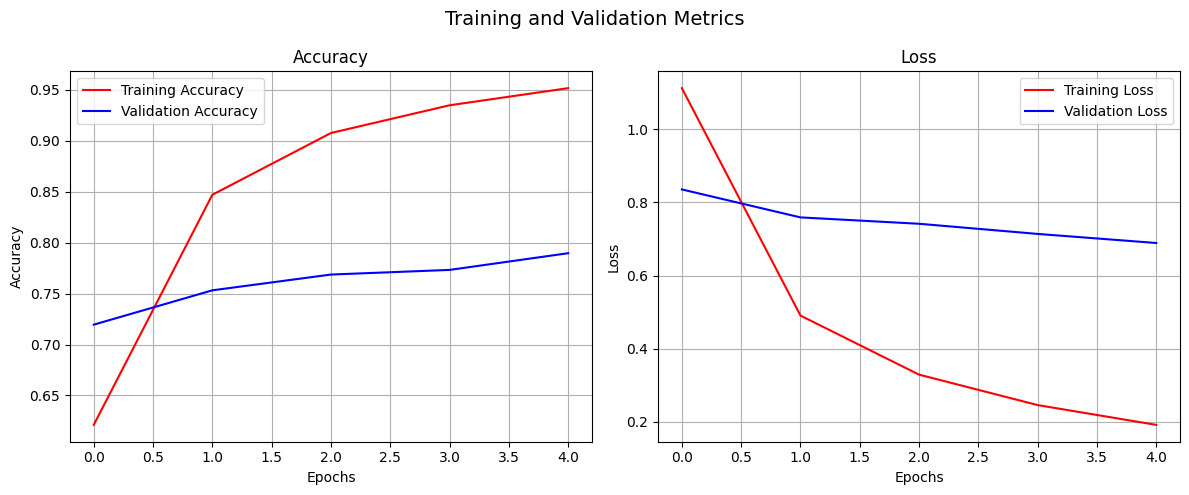

In [45]:
import matplotlib.pyplot as plt  # Pastikan penulisan benar

# Contoh asumsi variabel history (untuk memberikan konteks):
# history = model.fit(...)

# Mendapatkan akurasi dan loss dari pelatihan dan validasi
acc = history_densenet.history['accuracy']
val_acc = history_densenet.history['val_accuracy']
loss = history_densenet.history['loss']
val_loss = history_densenet.history['val_loss']

# Mendapatkan jumlah epoch
epochs = range(len(acc))

# Membuat subplots untuk akurasi dan loss
fig, ax = plt.subplots(1, 2, figsize=(12, 5))  # Lebar disesuaikan untuk visualisasi lebih baik
fig.suptitle('Training and Validation Metrics', fontsize=14)

# Plot akurasi
ax[0].plot(epochs, acc, 'r', label="Training Accuracy")
ax[0].plot(epochs, val_acc, 'b', label="Validation Accuracy")
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()
ax[0].grid()

# Plot loss
ax[1].plot(epochs, loss, 'r', label="Training Loss")
ax[1].plot(epochs, val_loss, 'b', label="Validation Loss")
ax[1].set_title('Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[1].grid()

# Menampilkan plot
plt.tight_layout()
plt.show()



In [47]:
# Simpan model yang sudah dilatih
densenet_model.save('densenet_model.h5')
print("Model berhasil disimpan.")

Model berhasil disimpan.


In [49]:
from tensorflow.keras.models import load_model

# Muat kembali model yang telah disimpan
model = load_model('densenet_model.h5')
print("Model berhasil dimuat.")

Model berhasil dimuat.


In [79]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Fungsi untuk memuat dan memproses gambar
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(180, 180))  # Sesuaikan ukuran dengan input model
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Tambahkan batch dimension
    img_array = img_array / 255.0  # Normalisasi
    return img_array

# Masukkan path gambar baru
image_path = 'C:/Dataset/images5.jpeg'
input_image = preprocess_image(image_path)

# Prediksi
predictions = model.predict(input_image)
predicted_class = np.argmax(predictions)
confidence = np.max(predictions)
 
labels = ["Acne",
    "Actinic Cheilitis",
    "Actinic Keratosis",
    "Basall Cell Carcinoma",
    "Bullous Disease",
    "Cacar Air",
    "Eczema",
    "Infeksi Jamur",
    "Kutil",
    "Skin Cancer",
    "Urticaria Hives",]  
print(f"Prediksi: {labels[predicted_class]} dengan kepercayaan {confidence:.2f}")


1/1 [==============================] - 0s 126ms/step
Prediksi: Basall Cell Carcinoma dengan kepercayaan 0.89
